# Alura - TensorFlow Keras: Decodificando Áudio com IA

## Explorando o reconhecimento de áudio

### Carregando os dados

In [1]:
gz_path = '/content/drive/MyDrive/IA/Data/dataset_commands-002.gz'

In [2]:
! pip install tensorflow

In [3]:
import tensorflow as tf
import pathlib
import gzip
import shutil
import numpy as np

In [4]:
def ler_arquivos(gz_path):
    extracted_path = '/content/dataset_commands'

    with gzip.open(gz_path, 'rb') as f_in:
        with open(extracted_path + '.tar', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    # Extrair o arquivo .tar resultante
    shutil.unpack_archive(extracted_path + '.tar', extracted_path)

    data_dir = pathlib.Path(extracted_path)

    all_audio_paths = list(data_dir.glob('*/**/*.wav'))
    all_labels = [path.parent.name for path in all_audio_paths]

    # Converter caminhos para strings
    all_audio_paths = [str(path) for path in all_audio_paths]

    return all_audio_paths, all_labels

In [5]:
all_audio_paths, all_labels = ler_arquivos(gz_path)

In [6]:
np.unique(all_labels)

array(['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog',
       'down', 'eight', 'five', 'follow', 'forward', 'four', 'go',
       'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off',
       'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three',
       'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero'], dtype='<U18')

In [7]:
np.unique(all_labels).shape

(36,)

In [8]:
import matplotlib.pyplot as plt

In [9]:
example_audio_path = all_audio_paths[0]
example_audio_path

'/content/dataset_commands/zero/6d0ad764_nohash_0.wav'

In [10]:
audio_binary = tf.io.read_file(example_audio_path)
audio, _ = tf.audio.decode_wav(audio_binary)
audio = tf.squeeze(audio, axis=-1)
audio

<tf.Tensor: shape=(14861,), dtype=float32, numpy=
array([0.00219727, 0.00384521, 0.003479  , ..., 0.00384521, 0.0038147 ,
       0.003479  ], dtype=float32)>

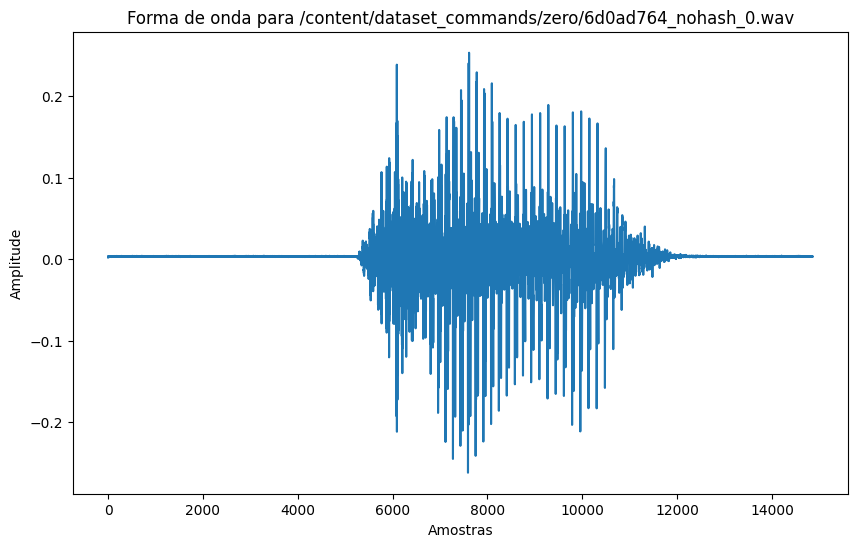

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(audio.numpy())
plt.title(f'Forma de onda para {example_audio_path}')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.show()

### Processando os dados de áudio

In [12]:
from scipy.signal import resample

In [13]:
def load_and_process_audio(filename, max_length=16000):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)

    def scipy_resample(wav, sample_rate):
        if sample_rate != max_length:
            wav = resample(wav, int(max_length / sample_rate * len(wav)))
        return wav

    wav = tf.py_function(scipy_resample, [wav, sample_rate], tf.float32)

    audio_length = tf.shape(wav)[0]
    # Se o áudio for maior que o máximo, corta
    if audio_length > max_length:
        wav = wav[:max_length]
    # Se o aúdio for menor que o máximo, adiciona zeros
    else:
        pad_length = max_length - audio_length
        paddings = [[0, pad_length]]
        wav = tf.pad(wav, paddings, 'CONSTANT')

    return tf.reshape(wav, [max_length])

In [14]:
def process_path(file_path, label):
    audio = load_and_process_audio(file_path)
    return audio, label

In [15]:
def paths_and_labels_to_dataset(audio_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    audio_label_ds = tf.data.Dataset.zip((path_ds, label_ds))
    return audio_label_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
def prepare_for_training(ds, batch_size=32, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [18]:
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels)

In [19]:
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_audio_paths,
    all_labels_encoded,
    test_size=0.02,
    random_state=42,
    stratify=all_labels_encoded
)

In [20]:
train_dataset = paths_and_labels_to_dataset(train_paths, train_labels)

In [21]:
val_dataset = paths_and_labels_to_dataset(val_paths, val_labels)

In [22]:
train_dataset = prepare_for_training(train_dataset)
val_dataset = prepare_for_training(val_dataset)

### Treinando a rede

In [23]:
from tensorflow.keras import layers, models

In [24]:
model_time_domain = models.Sequential([
    layers.Input(shape=(16000, 1)),
    layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=36, activation='softmax')
])

In [25]:
model_time_domain.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
history_time_domain = model_time_domain.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)

Epoch 1/10
1636/3242 ━━━━━━━━━━━━━━━━━━━━ 1:59 74ms/step - accuracy: 0.0977 - loss: 3.3256

KeyboardInterrupt: 

In [41]:
def plot_history(history):
    # Resumo do histórico de precisão
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
    plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    plt.title('Acurácia do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend(loc='lower right')

    # Resumo do histórico de perda
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treinamento')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Perda do Modelo')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
plot_history(history_time_domain)

## Mudando o domínio

### Aplicando a FFT (Transformada Rápida de Fourier)

- Converte dados do domínio do tempo para o domínio da frequência

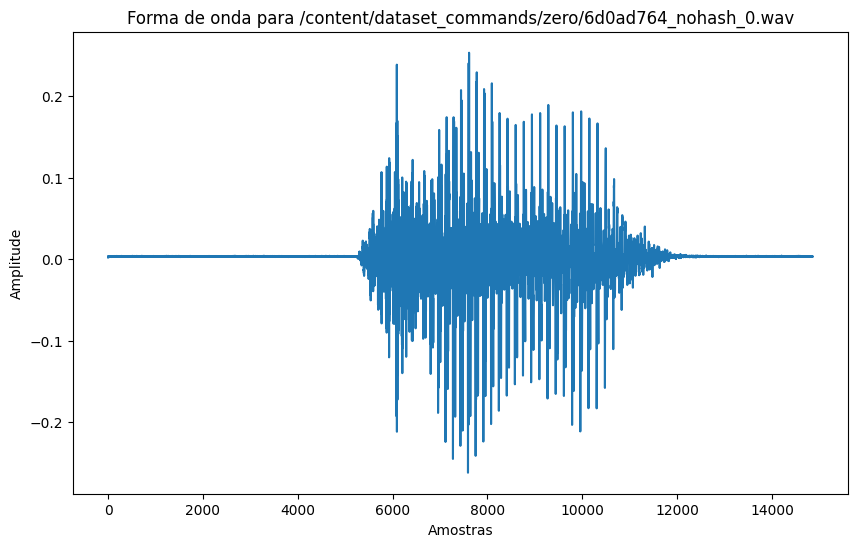

In [27]:
# Plotar a forma de onda
plt.figure(figsize=(10, 6))
plt.plot(audio.numpy())
plt.title(f'Forma de onda para {example_audio_path}')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.show()

In [28]:
def espectrograma(formadeonda):
    # Passa o dado do domínio do tempo para o domínio da frequência
    espect = tf.signal.stft(formadeonda, frame_length=255, frame_step=128)
    espect = tf.abs(espect)

    espect = espect[..., tf.newaxis]
    return espect

- A STFT ("short-time Fourier transform", em português, "Transformada de Fourier de curta duração") é uma técnica que converte dados do domínio do tempo para o domínio da frequência com maior precisão. Ela divide a forma de onda em janelas ou cortes e aplica a transformação de Fourier a cada uma desses cortes.

In [29]:
espect = espectrograma(audio.numpy())

In [30]:
def plota_espectrograma(espectrograma):
    if len(espectrograma.shape) > 2:
        assert len(espectrograma.shape) == 3
        espectrograma = np.squeeze(espectrograma, axis=-1)

    log_spec = np.log(espectrograma.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(espectrograma), num=width, dtype=int)
    Y = range(height)
    plt.pcolormesh(X, Y, log_spec)

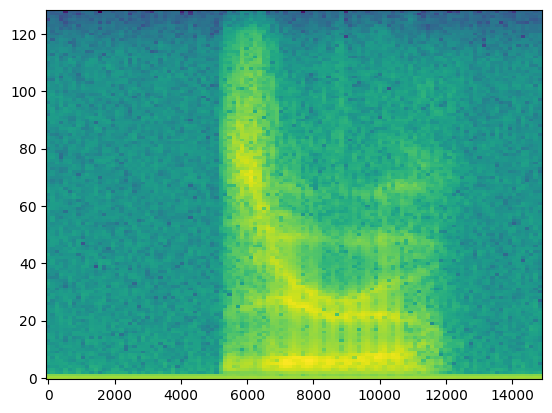

In [31]:
plota_espectrograma(espect)

### Reprocessando os dados

- Será necessário passar os dados para o domínio da frequência

In [32]:
def get_spectrogram_and_label_id(audio, label):
    espect = espectrograma(audio)
    return espect, label

In [33]:
train_spec = train_dataset.map(map_func=get_spectrogram_and_label_id,
                               num_parallel_calls=tf.data.AUTOTUNE)
val_spec = val_dataset.map(map_func=get_spectrogram_and_label_id,
                               num_parallel_calls=tf.data.AUTOTUNE)

In [34]:
norm_layer = tf.keras.layers.Normalization()

for spectrogram, _ in train_spec.take(1):
    norm_layer.adapt(spectrogram)
    input_shape = spectrogram.shape[1:]

In [35]:
num_labels = len(np.unique(all_labels))

### Adaptando a rede

In [36]:
input_shape

TensorShape([124, 129, 1])

In [37]:
model_spectrogram = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

- A camada layers.Flatten() é responsável por converter a matriz 2D resultante das camadas convolucionais em um vetor unidimensional, permitindo que as próximas camadas densas realizem a classificação.

In [38]:
model_spectrogram.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [39]:
history_spectrogram = model_spectrogram.fit(
    train_spec,
    epochs=10,
    validation_data=val_spec
)

Epoch 1/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 166s 49ms/step - accuracy: 0.3433 - loss: 2.3467 - val_accuracy: 0.7355 - val_loss: 0.9407
Epoch 2/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 145s 45ms/step - accuracy: 0.6438 - loss: 1.2065 - val_accuracy: 0.7737 - val_loss: 0.7659
Epoch 3/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 201s 44ms/step - accuracy: 0.7002 - loss: 1.0028 - val_accuracy: 0.8049 - val_loss: 0.6625
Epoch 4/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 202s 44ms/step - accuracy: 0.7302 - loss: 0.8966 - val_accuracy: 0.8328 - val_loss: 0.5925
Epoch 5/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 146s 45ms/step - accuracy: 0.7526 - loss: 0.8202 - val_accuracy: 0.8432 - val_loss: 0.5557
Epoch 6/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 199s 44ms/step - accuracy: 0.7661 - loss: 0.7674 - val_accuracy: 0.8309 - val_loss: 0.5544
Epoch 7/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 143s 44ms/step - accuracy: 0.7798 - loss: 0.7264 - val_accuracy: 0.8351 - val_loss: 0.5464
Epoch 8/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 146s 45ms/step - accuracy: 

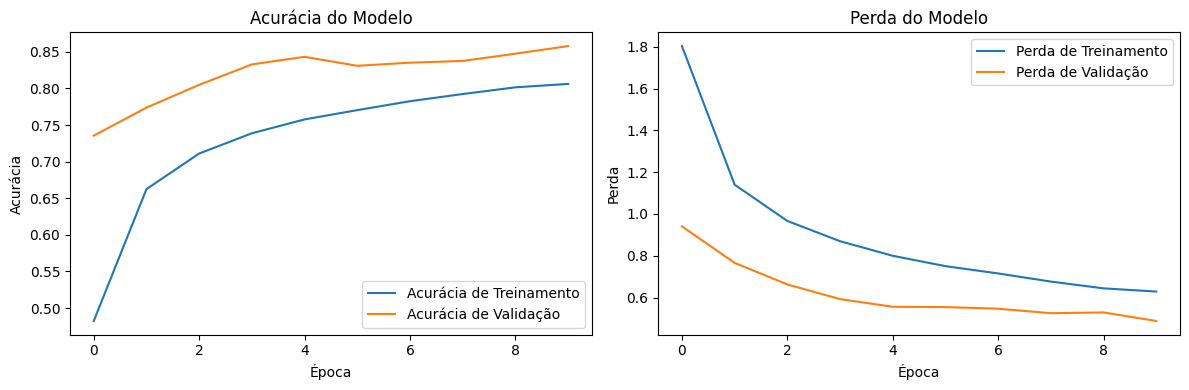

In [43]:
plot_history(history_spectrogram)

## Mecanismos de atenção

### Implementando uma camada de atenção de canal

In [47]:
# Classe definida como uma camada do Keras
@tf.keras.utils.register_keras_serializable()
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        # As camadas de pooling vão ajudar a focar em partes específicas dos dados
        # Reduzirá a dimensionalidade, enfatizando as características mais importantes
        self.ratio = ratio
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()

    def build(self, input_shape):
        self.fc1 = layers.Dense(units=input_shape[-1] //
                                self.ratio, activation='relu')
        self.fc2 = layers.Dense(units=input_shape[-1], activation='sigmoid')

    def call(self, inputs):
        avg_out = self.avg_pool(inputs)
        max_out = self.max_pool(inputs)
        avg_out = self.fc2(self.fc1(avg_out))
        max_out = self.fc2(self.fc1(max_out))
        out = avg_out + max_out
        out = tf.expand_dims(tf.expand_dims(out, axis=1), axis=1)
        return inputs * out

- Basicamente, multiplicamos a entrada pela saída da camada para ajustar o foco da rede neural nas partes mais importantes dos dados.

- Imagine que estamos tentando resolver um problema de classificação de imagens onde queremos identificar o surfista dentro da imagem. A rede neural dá mais atenção às regiões onde o surfista aparece, atribuindo valores mais altos a essas áreas.

- Usando avg pooling (média) e max pooling (valores máximos), enfatizamos as características importantes da imagem após o processamento. Isso ajuda a rede a focar nas partes mais relevantes, melhorando sua capacidade de identificar corretamente o surfista e, assim, aumentar a precisão da classificação.

In [48]:
model_spectrogram = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    ChannelAttention(ratio=8),
    layers.Conv2D(64, 3, activation='relu'),
    ChannelAttention(ratio=8),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

In [49]:
model_spectrogram.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_spectrogram = model_spectrogram.fit(
    train_spec,
    epochs=10,
    validation_data=val_spec
)

Epoch 1/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 200s 59ms/step - accuracy: 0.3552 - loss: 2.2936 - val_accuracy: 0.7492 - val_loss: 0.8508
Epoch 2/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 176s 54ms/step - accuracy: 0.6621 - loss: 1.1300 - val_accuracy: 0.7964 - val_loss: 0.6855
Epoch 3/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 183s 48ms/step - accuracy: 0.7211 - loss: 0.9246 - val_accuracy: 0.8177 - val_loss: 0.5929
Epoch 4/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 191s 45ms/step - accuracy: 0.7536 - loss: 0.8166 - val_accuracy: 0.8262 - val_loss: 0.5624
Epoch 5/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 204s 45ms/step - accuracy: 0.7741 - loss: 0.7413 - val_accuracy: 0.8413 - val_loss: 0.5176
Epoch 6/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 200s 45ms/step - accuracy: 0.7875 - loss: 0.6904 - val_accuracy: 0.8418 - val_loss: 0.5114
Epoch 7/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 201s 44ms/step - accuracy: 0.7995 - loss: 0.6509 - val_accuracy: 0.8512 - val_loss: 0.4768
Epoch 8/10
 861/3242 ━━━━━━━━━━━━━━━━━━━━ 1:42 43ms/step - accuracy: 

In [ ]:
plot_history(history_spectrogram)

### Salvando e fazendo uma inferência

In [ ]:
specific_audio_path = ''

In [ ]:
specific_audio = load_and_process_audio(specific_audio_path)

In [ ]:
specific_spectrogram = espectrograma(specific_audio.numpy())

In [ ]:
# Expandir a dimensão do batch para compatibilidade com o modelo
specific_spectrogram = np.expand_dims(specific_spectrogram, axis=0)

In [ ]:
specific_prediction = model_spectrogram.predict(specific_spectrogram)
specific_prediction

In [ ]:
specific_prediction_label = np.argmax(specific_prediction, axis=-1)[0]
specific_prediction_label

In [ ]:
label_encoder.inverse_transform([specific_prediction_label])[0]

In [ ]:
#model_spectrogram.save('model_spectrogram.keras')